## Material produzido no estudo de análise de dados aplicados as finanças

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import date, timedelta
from scipy import stats 
from sklearn.metrics import root_mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# configuração dos gráficos 
from matplotlib import rc
# estilo dos gráficos #https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.style.use('Solarize_Light2')
%config InlineBackend.figure_format = 'retina'  # formato das imagens
rc('font', **{"family":"sans-serif","sans-serif":["DejaVu Sans"], "size":9})

rc('mathtext', **{"default":"regular"})

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from pmdarima import auto_arima
from pmdarima.arima import ADFTest
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Define the date range
start_date = date.today() - timedelta(days=365)
end_date = date.today()

# List of stocks and corresponding company names
stocks = ['POMO4.SA', 'WEGE3.SA', 'PETR4.SA', 'BTLG11.SA', 'B3SA3.SA']
company_names = ["Marcopolo", "Weg", "Petrobras", "BTG logística", "Bovespa"]

# Initialize a dictionary to store different types of price data
price_data_dict = {key: [] for key in ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']}

def merge_dataframes(data_list):
    """Merge a list of DataFrames on the 'Date' column."""
    if not data_list:
        return None
    
    merged_df = data_list[0]
    if isinstance(merged_df.columns, pd.MultiIndex):
        merged_df.columns = merged_df.columns.get_level_values(0)

    for df in data_list[1:]:
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)
        merged_df = pd.merge(merged_df, df, on='Date', how='outer')
    
    return merged_df

def download_and_prepare_stock_data(stock_symbol, company_name):
    """Download stock data and prepare it for processing."""
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date).reset_index()
    
    for price_type in price_data_dict:
        if price_type in stock_data.columns:
            price_df = stock_data[['Date', price_type]].rename(columns={price_type: company_name})
            price_data_dict[price_type].append(price_df)

# Download and prepare data for each stock
for stock_symbol, company_name in zip(stocks, company_names):
    download_and_prepare_stock_data(stock_symbol, company_name)

# Combine all price type dataframes
df_adj_close = merge_dataframes(price_data_dict['Adj Close'])
df_adj_close['Carteira'] = df_adj_close.iloc[:, 1:5].sum(axis=1)
df_close = merge_dataframes(price_data_dict['Close'])
df_high = merge_dataframes(price_data_dict['High'])
df_low = merge_dataframes(price_data_dict['Low'])
df_open = merge_dataframes(price_data_dict['Open'])
df_volume = merge_dataframes(price_data_dict['Volume'])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
df_adj_close.describe().round(3)

Price,Marcopolo,Weg,Petrobras,BTG logística,Bovespa,Carteira
count,252.000,252.000,252.000,252.000,252.000,252.000
mean,6.963,42.343,35.346,97.162,11.778,181.815
std,0.799,8.175,2.317,2.541,1.097,11.646
min,5.532,31.818,29.440,90.798,9.913,160.011
25%,6.426,36.024,33.846,95.876,10.787,173.506
50%,6.833,38.573,35.903,97.219,11.700,178.816
75%,7.347,52.310,37.061,99.002,12.577,194.728
max,9.450,57.190,39.600,101.605,14.344,201.863


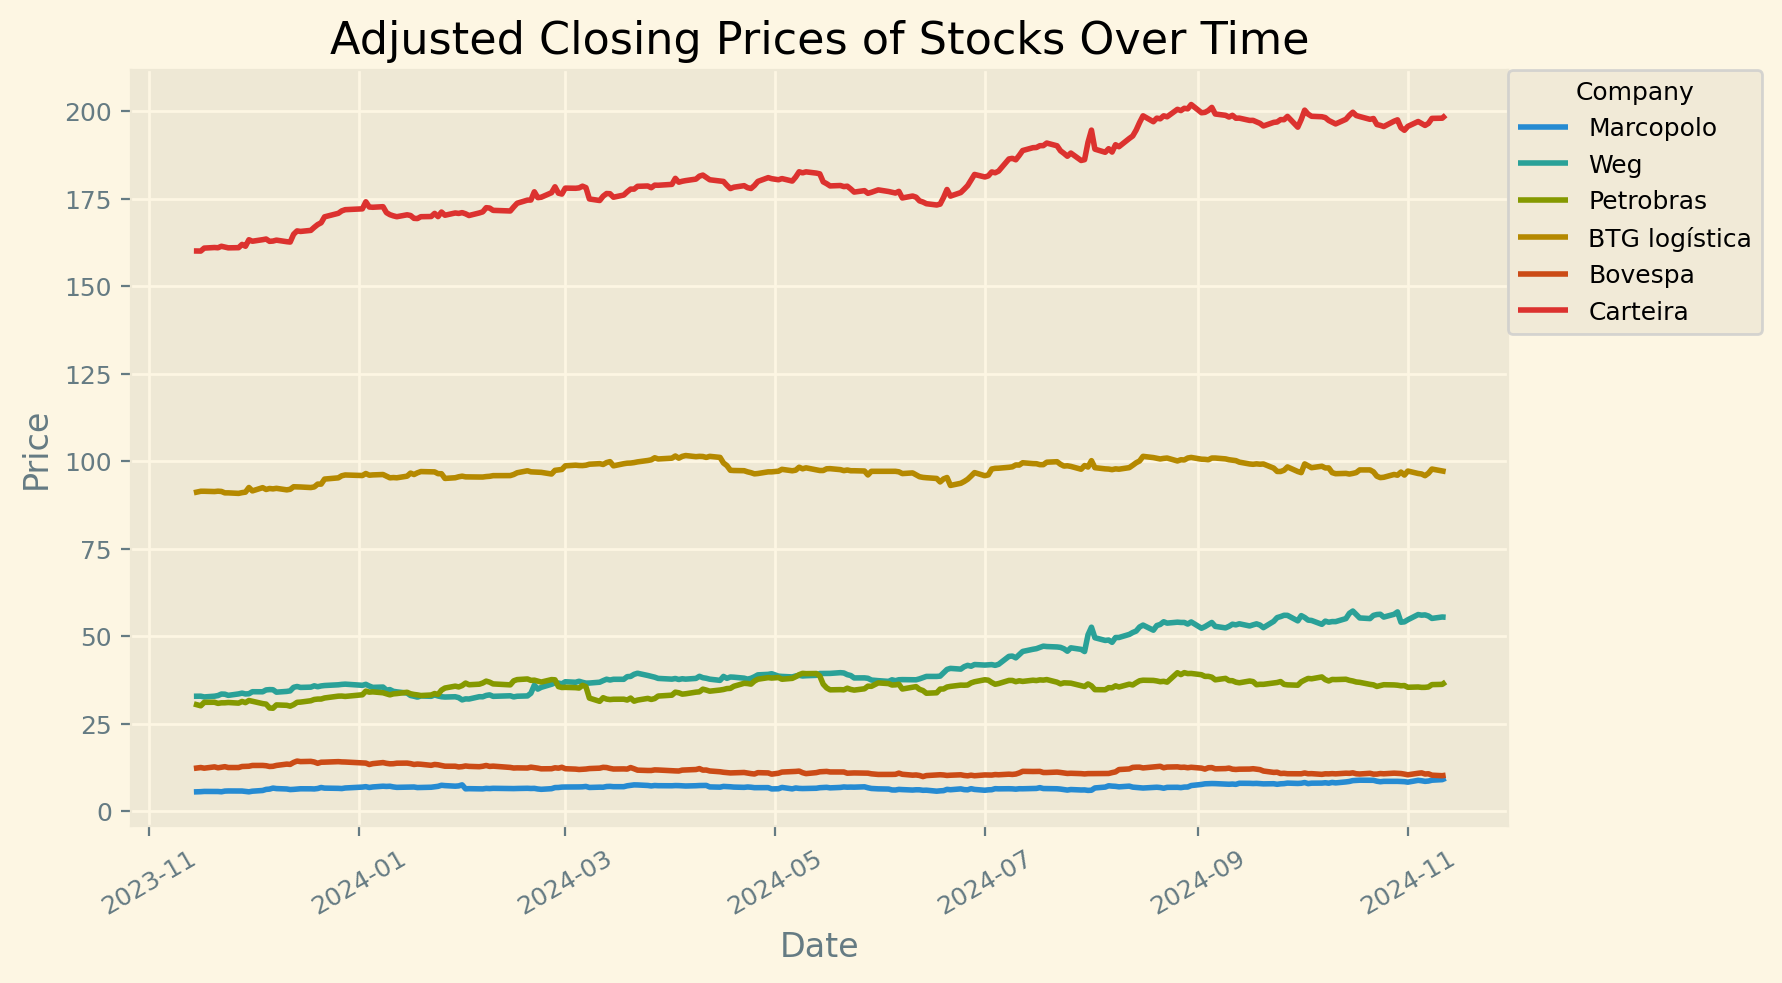

In [4]:
def plot_adjusted_closing_prices(melted_df, title='Adjusted Closing Prices of Stocks Over Time', figsize=(9, 5)):
    """
    Function to plot adjusted closing prices of stocks over time for a given melted DataFrame.
    
    Parameters:
    - melted_df (pd.DataFrame): The melted DataFrame containing 'Date', 'Company', and 'Price' columns.
    - title (str): The title of the plot.
    - figsize (tuple): The size of the figure (width, height).
    """
    # Check if the DataFrame contains the required columns
    required_columns = {'Date', 'Company', 'Price'}
    if not required_columns.issubset(melted_df.columns):
        raise ValueError(f"The DataFrame must contain the columns: {required_columns}")

    # Convert 'Date' column to datetime if not already
    if not pd.api.types.is_datetime64_any_dtype(melted_df['Date']):
        melted_df['Date'] = pd.to_datetime(melted_df['Date'])

    # Set the figure size
    plt.figure(figsize=figsize)

    # Create a line plot using seaborn for better aesthetics
    sns.lineplot(data=melted_df, x='Date', y='Price', hue='Company')

    # Customize the plot
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')

    # Show legend outside the plot
    plt.legend(title='Company', loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0.)

    # Add grid, rotate x-axis labels, and adjust layout
    plt.grid(True)
    plt.xticks(rotation=30)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage:
df_adj_close_melted = pd.melt(df_adj_close, id_vars=['Date'], var_name='Company', value_name='Price')
plot_adjusted_closing_prices(df_adj_close_melted)

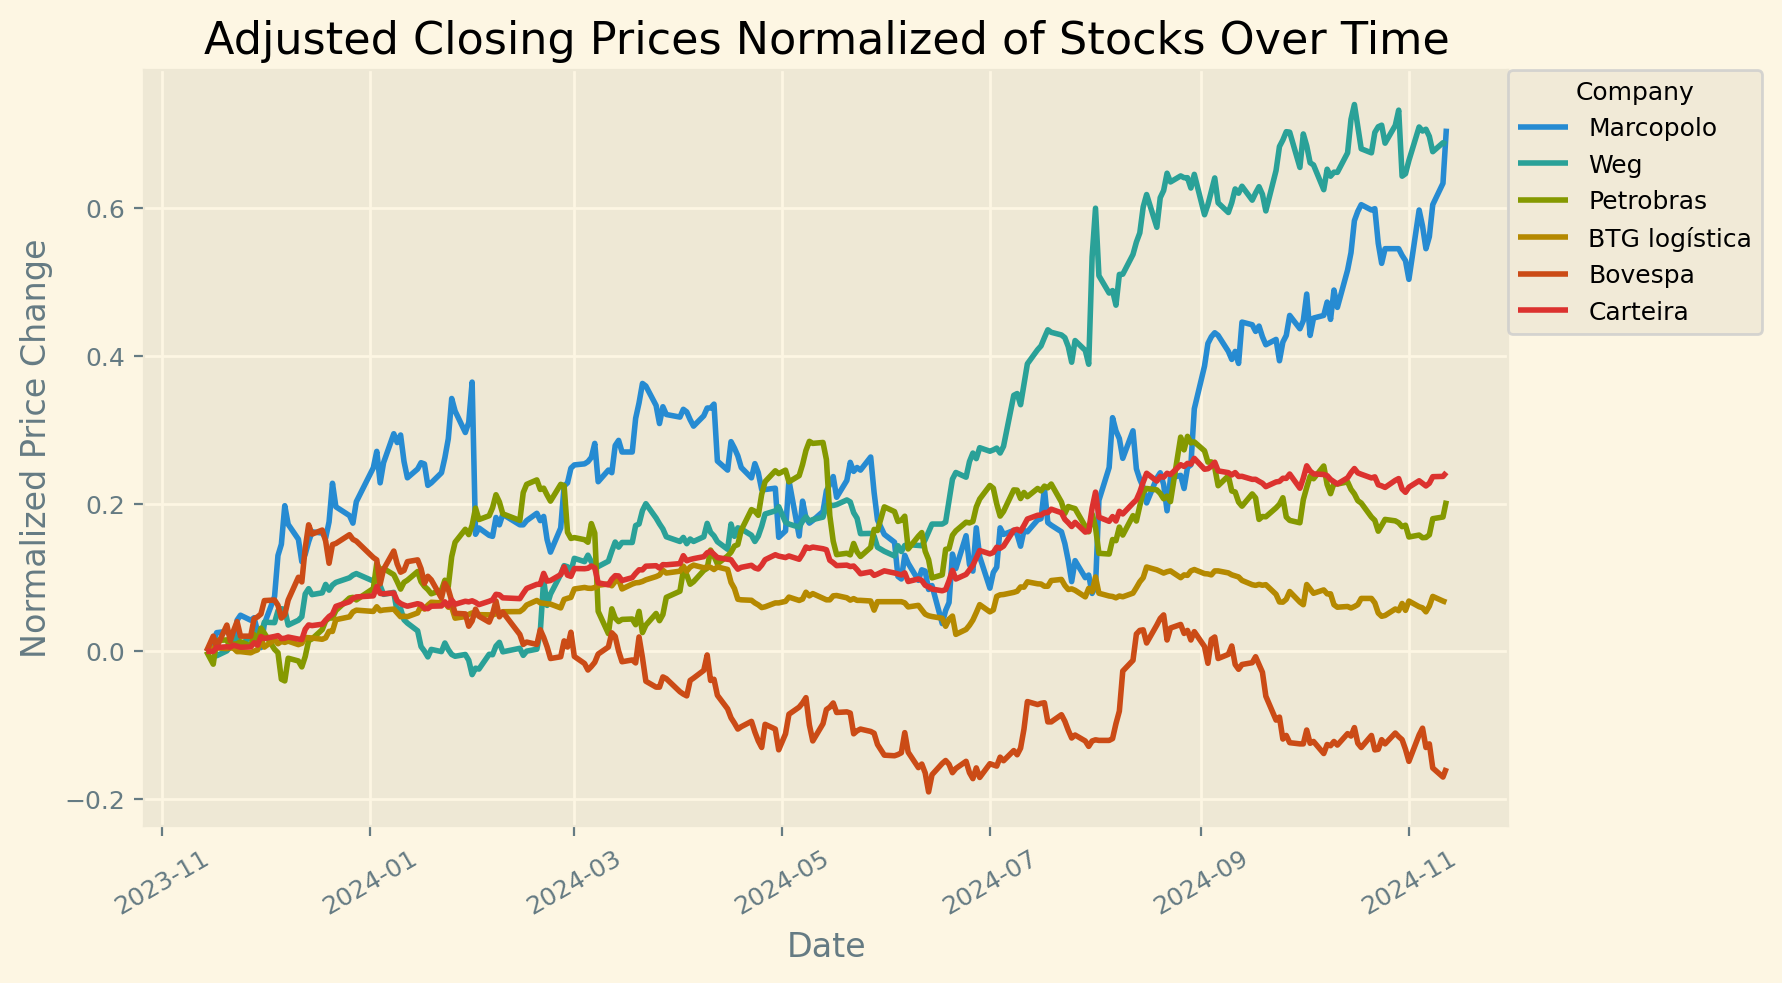

In [5]:
def plot_adjusted_closing_prices_normalized(melted_df, title='Adjusted Closing Prices Normalized of Stocks Over Time', figsize=(9, 5)):
    """
    Function to plot normalized adjusted closing prices of stocks over time for a given melted DataFrame.
    
    Parameters:
    - melted_df (pd.DataFrame): The melted DataFrame containing 'Date', 'Company', and 'Price' columns.
    - title (str): The title of the plot.
    - figsize (tuple): The size of the figure (width, height).
    """
    # Check if the DataFrame contains the required columns
    required_columns = {'Date', 'Company', 'Price'}
    if not required_columns.issubset(melted_df.columns):
        raise ValueError(f"The DataFrame must contain the columns: {required_columns}")

    # Convert 'Date' column to datetime if not already
    if not pd.api.types.is_datetime64_any_dtype(melted_df['Date']):
        melted_df['Date'] = pd.to_datetime(melted_df['Date'])

    # Set the figure size
    plt.figure(figsize=figsize)

    # Create a line plot using seaborn for better aesthetics
    sns.lineplot(data=melted_df, x='Date', y='Price', hue='Company')

    # Customize the plot
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Normalized Price Change')

    # Show legend outside the plot
    plt.legend(title='Company', loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0.)

    # Add grid, rotate x-axis labels, and adjust layout
    plt.grid(True)
    plt.xticks(rotation=30)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Normalize the data by company
df_adj_close_normalized = df_adj_close.copy()
for column in df_adj_close_normalized.columns[1:]:
    df_adj_close_normalized[column] = (df_adj_close_normalized[column] / df_adj_close_normalized[column].iloc[0]) - 1

# Melt the normalized DataFrame
df_adj_close_melted_normalized = pd.melt(df_adj_close_normalized, id_vars=['Date'], var_name='Company', value_name='Price')

# Plot the normalized data
plot_adjusted_closing_prices_normalized(df_adj_close_melted_normalized)

## Médias Móveis


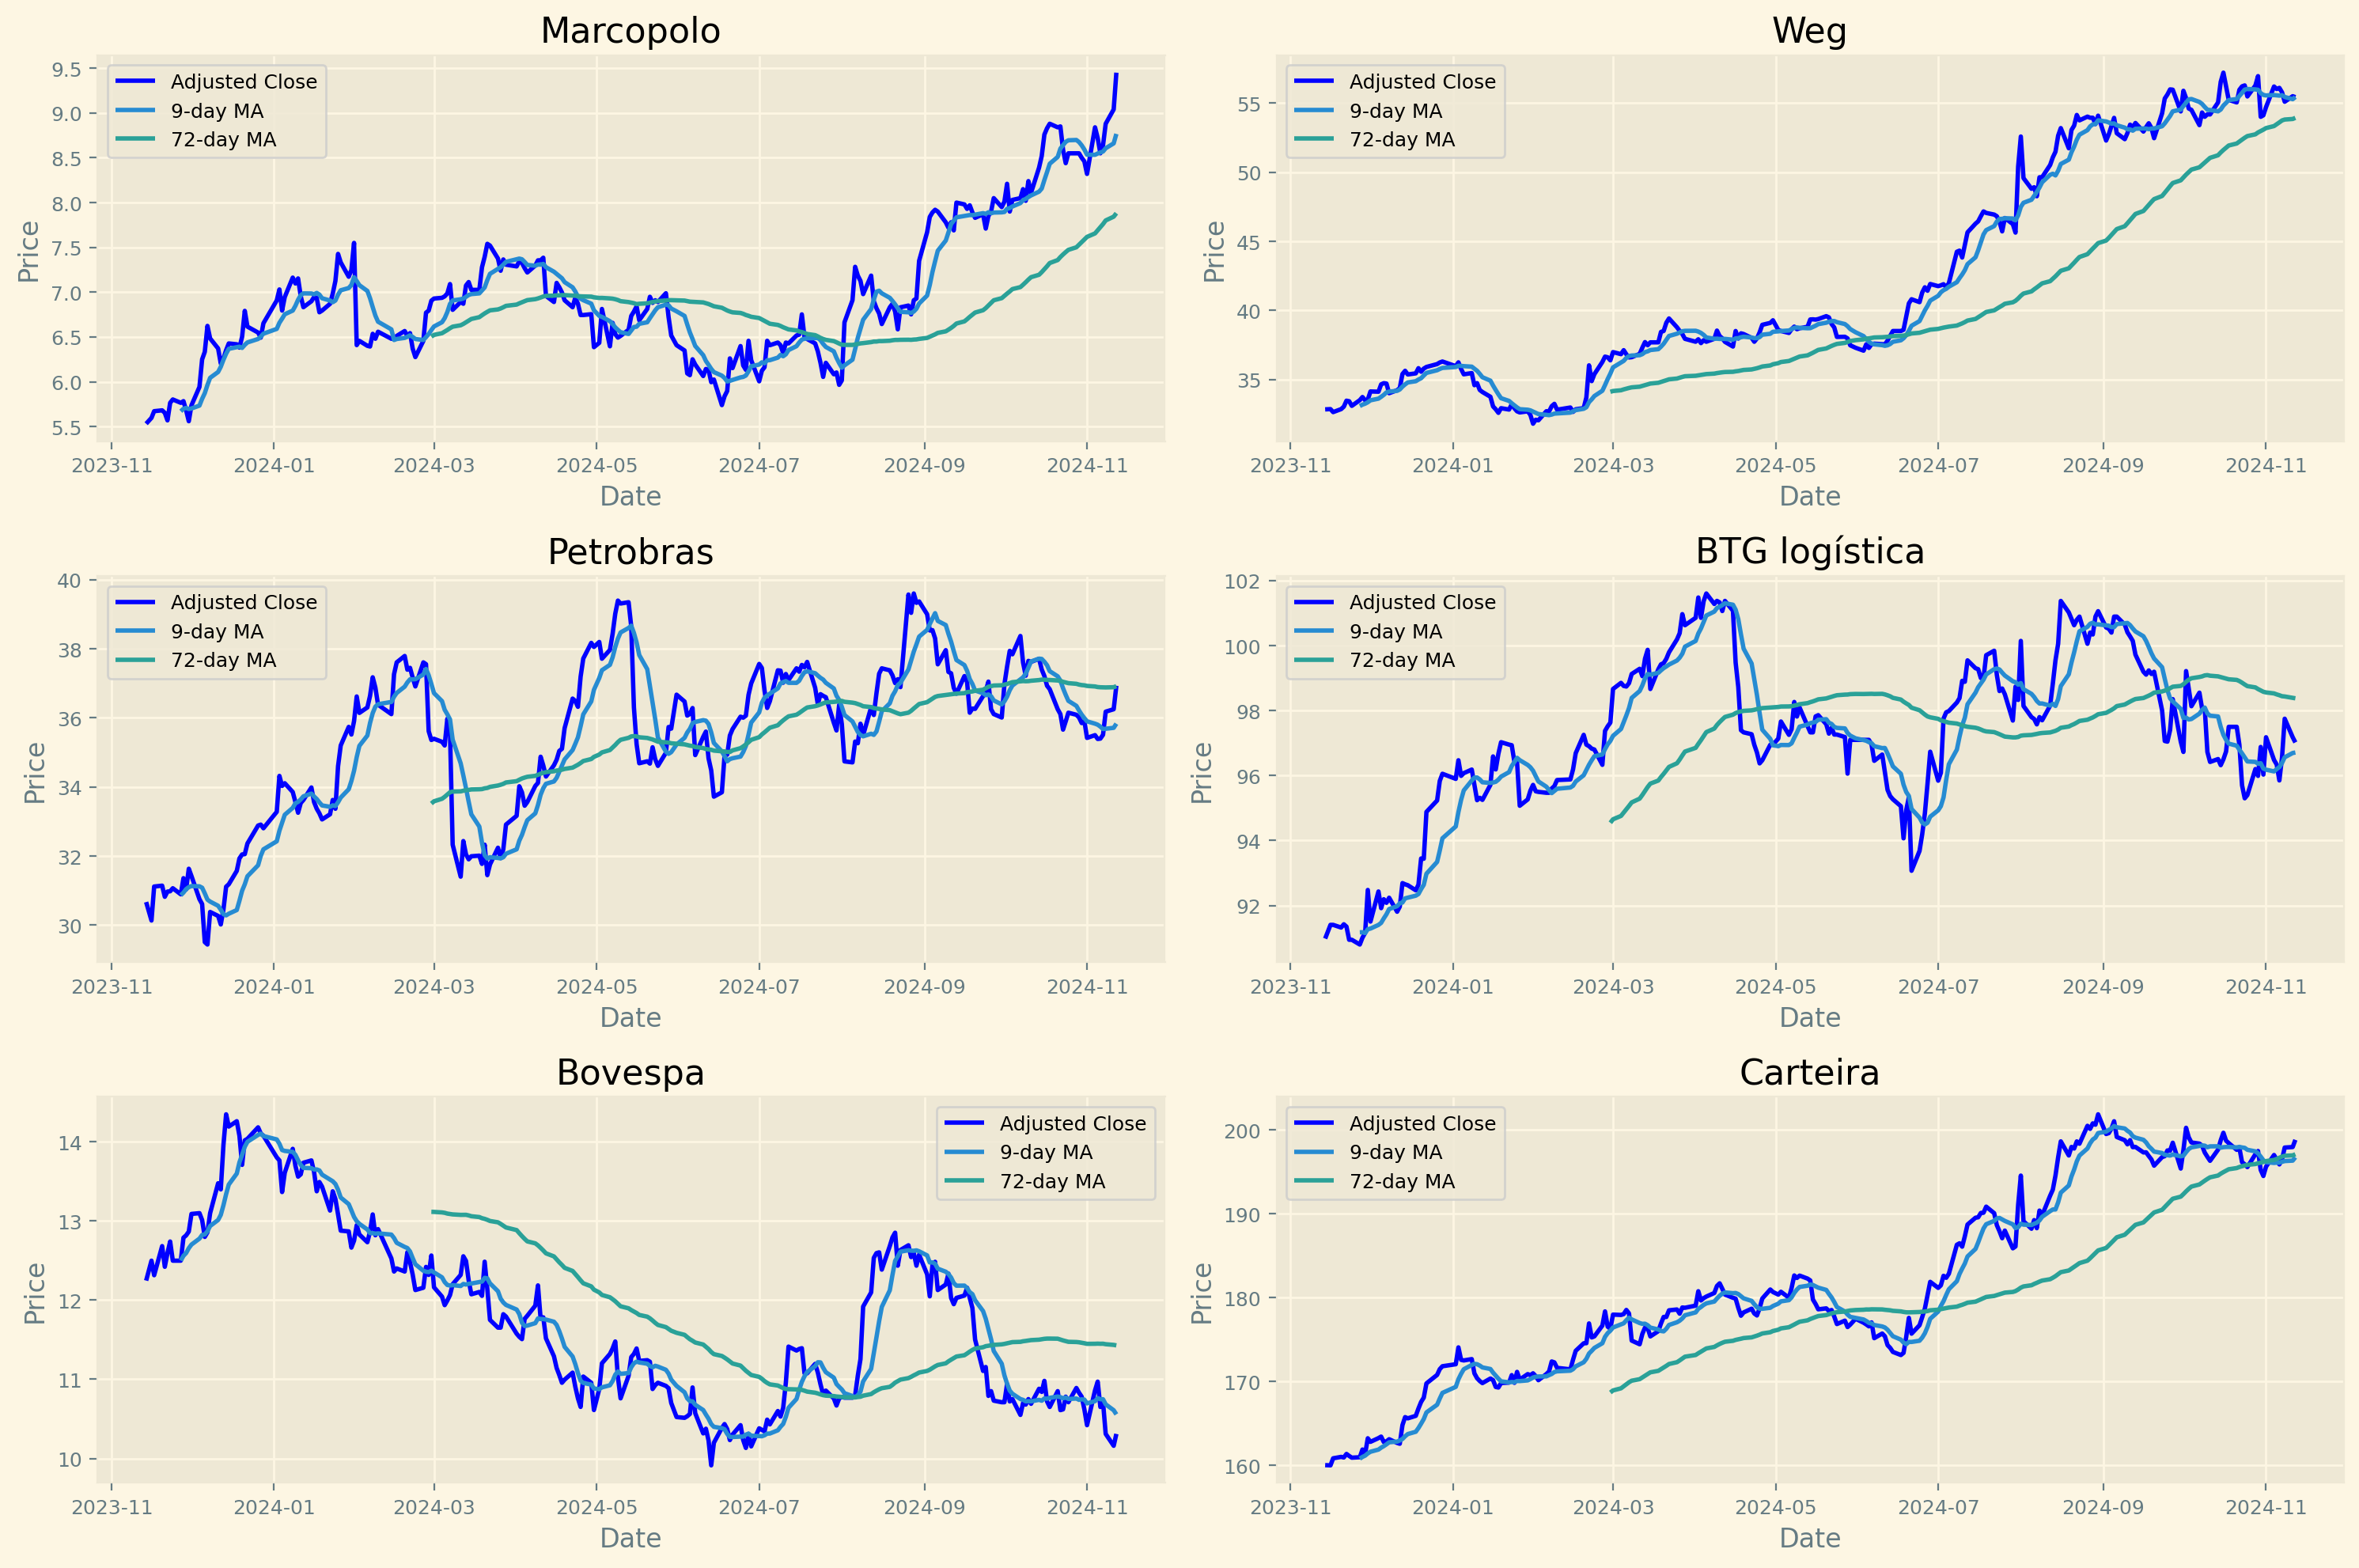

In [6]:
def calculate_and_plot_moving_averages(df_melted, company_names, ma_days=[9, 72], figsize=(15, 10)):
    """
    Function to calculate moving averages and plot them along with Adjusted Close prices.

    Parameters:
    - df_melted (pd.DataFrame): Melted DataFrame containing 'Date', 'Company', and 'Price'.
    - company_names (list): List of company names to plot.
    - ma_days (list): List of moving average periods.
    - figsize (tuple): Size of the figure (width, height).
    """
    # Verificar se as colunas necessárias estão presentes
    required_columns = {'Date', 'Company', 'Price'}
    if not required_columns.issubset(df_melted.columns):
        raise ValueError(f"O DataFrame deve conter as colunas: {required_columns}")

    # Adicionar colunas de médias móveis para cada empresa e período de média móvel
    for ma in ma_days:
        for company in company_names:
            # Filtrar dados para a empresa específica
            company_data = df_melted[df_melted['Company'] == company].copy()
            # Calcular a média móvel
            company_data[f"MA for {ma} days"] = company_data['Price'].rolling(ma).mean()
            # Mesclar a média móvel de volta ao DataFrame original
            df_melted.loc[df_melted['Company'] == company, f"MA for {ma} days"] = company_data[f"MA for {ma} days"]

    # Configurar subplots dinamicamente
    num_companies = len(company_names)
    num_rows = (num_companies + 1) // 2
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=figsize)
    axes = axes.flatten()  # Flatten para fácil iteração

    # Plotar Preço Ajustado e Médias Móveis para cada empresa
    for i, company in enumerate(company_names):
        ax = axes[i]  # Determinar posição do subplot
        # Filtrar dados para a empresa atual
        company_data = df_melted[df_melted['Company'] == company]
        # Plotar o preço ajustado
        ax.plot(company_data['Date'], company_data['Price'], label='Adjusted Close', color='blue')
        # Plotar cada média móvel
        for ma in ma_days:
            ax.plot(company_data['Date'], company_data[f"MA for {ma} days"], label=f"{ma}-day MA")
        # Customizar o gráfico
        ax.set_title(company)
        ax.set_ylabel('Price')
        ax.set_xlabel('Date')
        ax.legend()
        ax.grid(True)

    # Ajustar layout para evitar sobreposição
    fig.tight_layout()

    # Mostrar o gráfico
    plt.show()

company_names = ["Marcopolo", "Weg", "Petrobras", "BTG logística", "Bovespa", "Carteira"]
calculate_and_plot_moving_averages(df_adj_close_melted, company_names)

## Taxas de retornos

### Retorno Simples do período

In [7]:
# Função para calcular e imprimir o retorno simples
def calculate_simple_return(column, df):
    """
    Calculate and print the simple return for a specific column in a DataFrame.
    
    Parameters:
    - column (str): The column name for which the simple return is calculated.
    - df (pd.DataFrame): The DataFrame containing the stock prices.
    """
    initial_price = df[column].iloc[0]
    final_price = df[column].iloc[-1]
    simple_return = round((final_price - initial_price) / initial_price, 4)
    print(f'Empresa: {column}, Retorno Simples: {simple_return}')

# Verificar se as colunas especificadas existem no DataFrame
columns_to_check = df_adj_close.columns[1:7]
missing_columns = [col for col in columns_to_check if col not in df_adj_close.columns]

if missing_columns:
    print(f"As seguintes colunas estão ausentes no DataFrame: {missing_columns}")
else:
    # Aplicar a função para as colunas selecionadas
    for column in columns_to_check:
        calculate_simple_return(column, df_adj_close)

Empresa: Marcopolo, Retorno Simples: 0.7081
Empresa: Weg, Retorno Simples: 0.6869
Empresa: Petrobras, Retorno Simples: 0.2041
Empresa: BTG logística, Retorno Simples: 0.0664
Empresa: Bovespa, Retorno Simples: -0.1581
Empresa: Carteira, Retorno Simples: 0.2423


## Retorno Diário

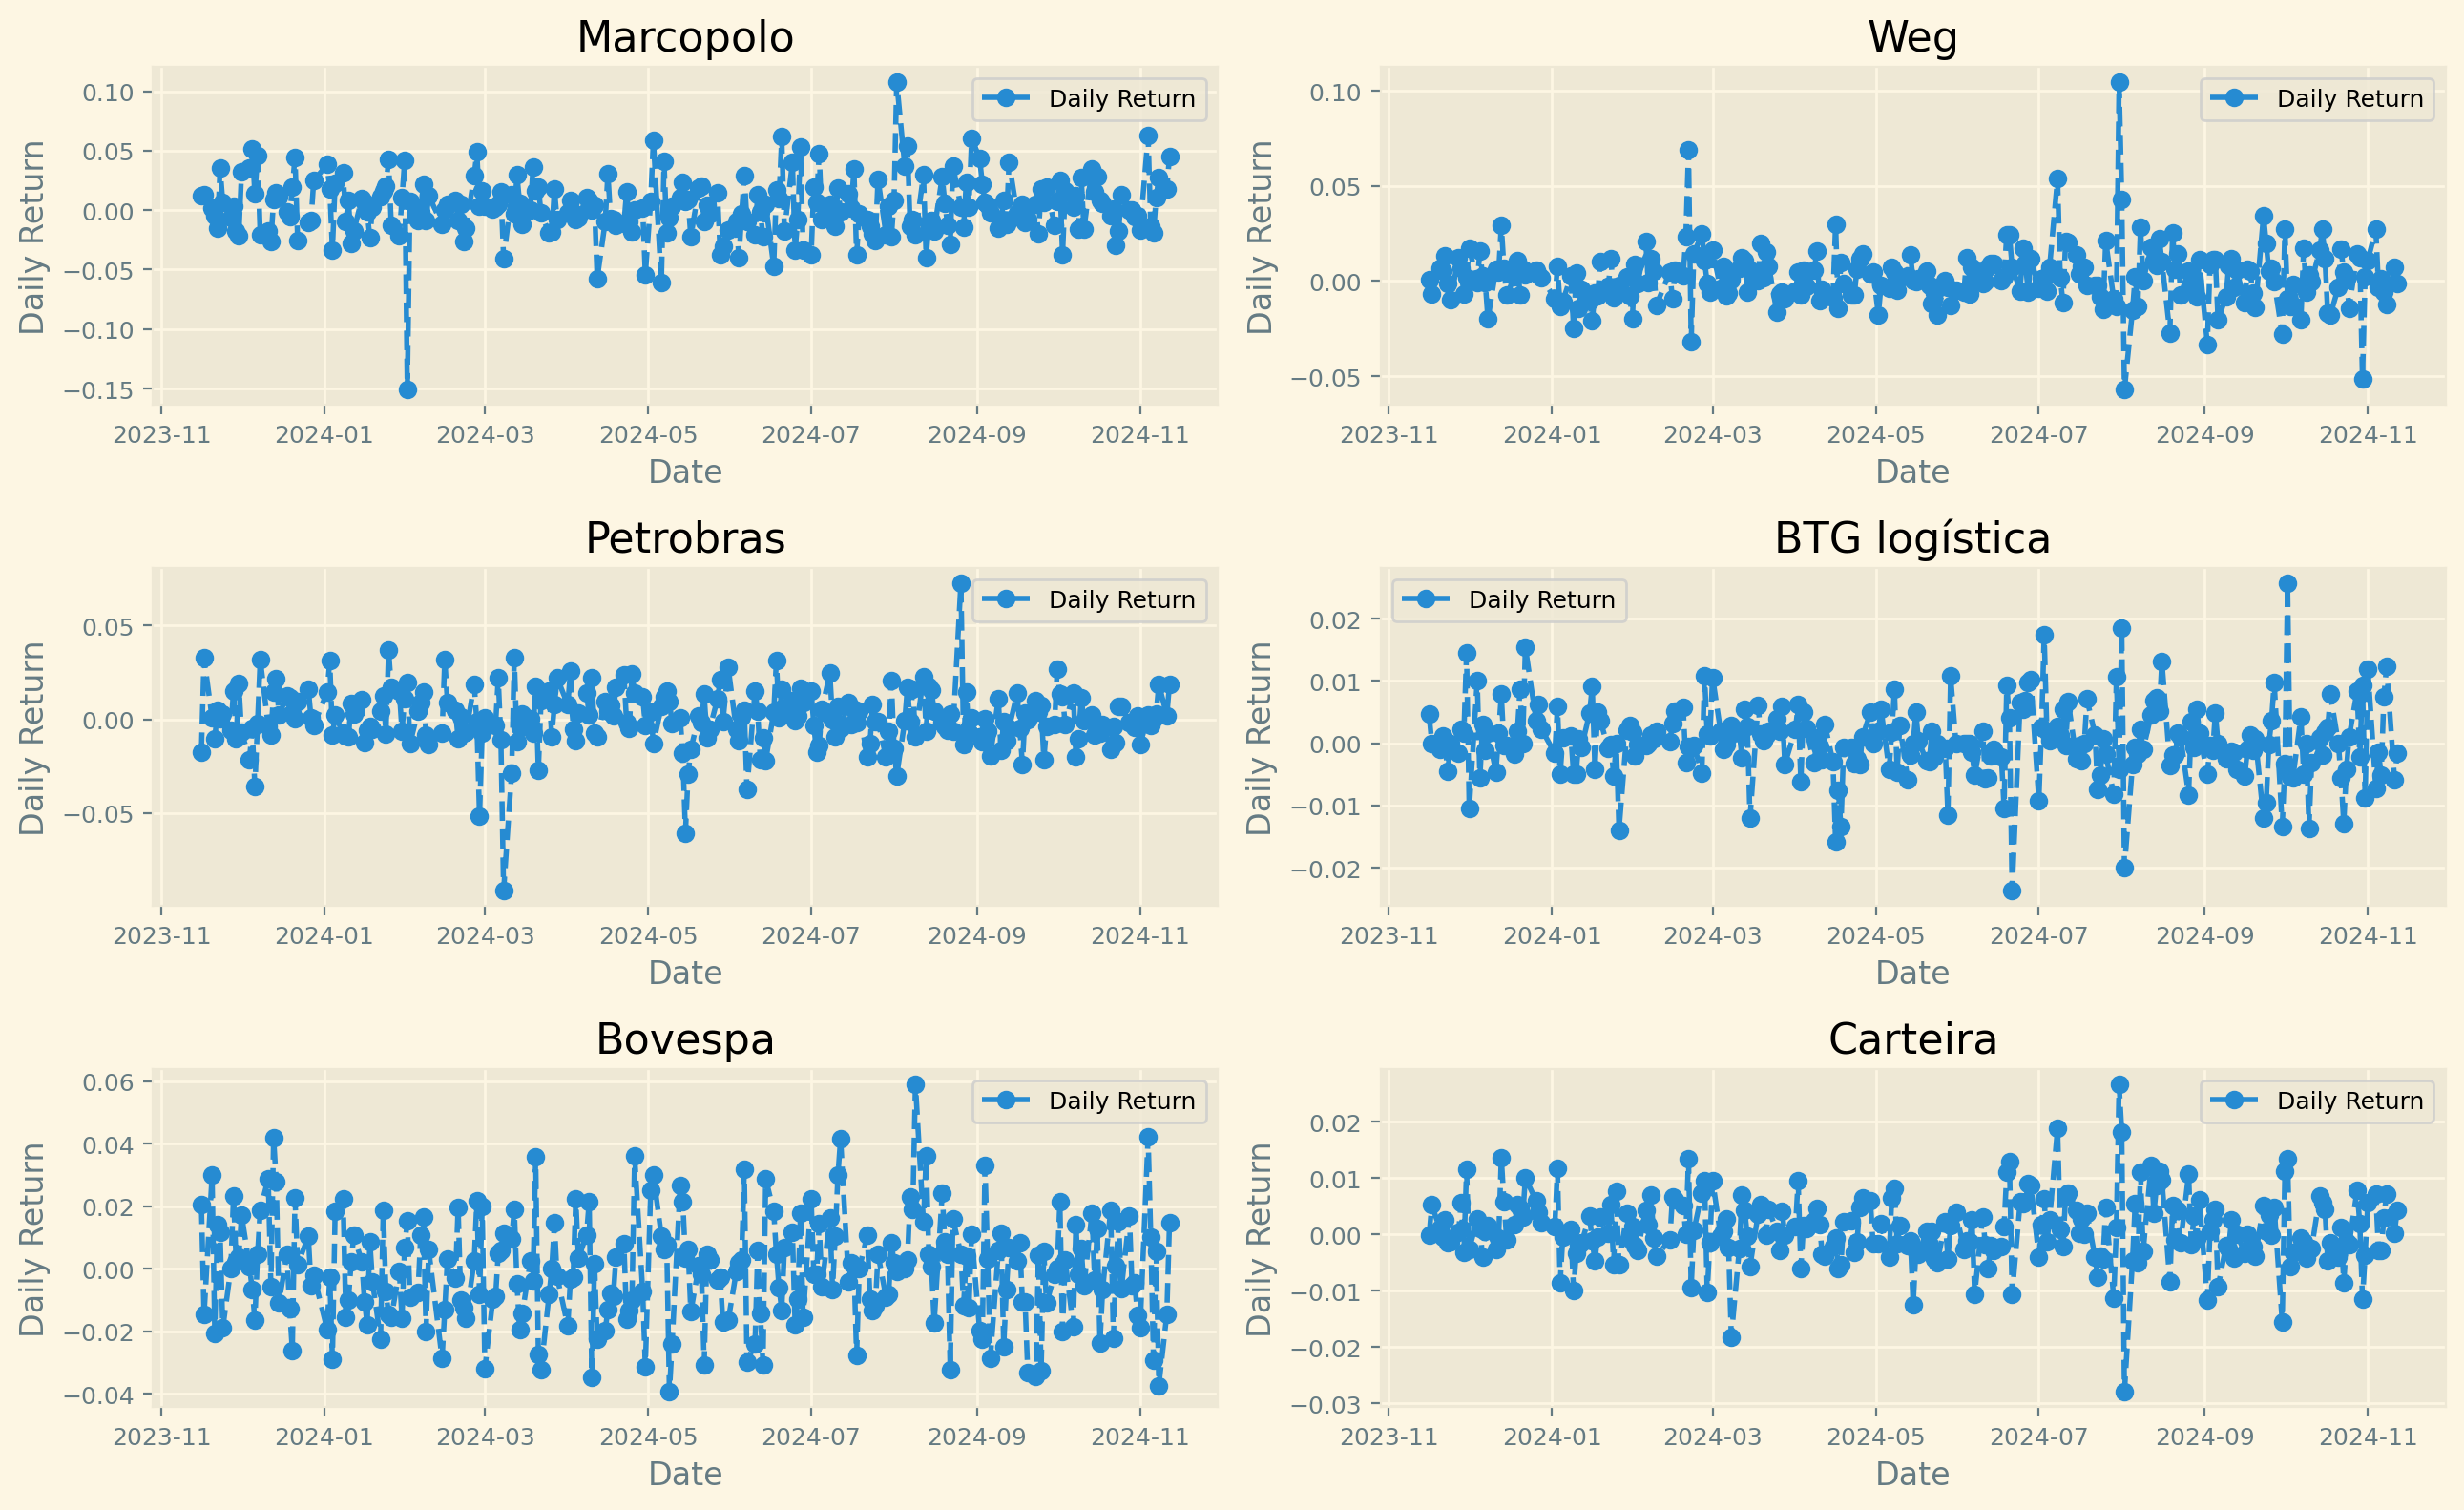

In [8]:
def calculate_and_plot_daily_returns(df_melted,  figsize=(13, 8)):
    """
    Function to calculate daily returns and plot them.

    Parameters:
    - df_melted (pd.DataFrame): Melted DataFrame containing 'Date', 'Company', and 'Price'.
    - company_name (list): List of company names.
    - figsize (tuple): Size of the figure (width, height).
    """
    # Add daily return columns for each company

    company_name = ["Marcopolo", "Weg", "Petrobras", "BTG logística", "Bovespa", "Carteira"]    
    for company in company_name:
        # Filter data for the specific company
        company_data = df_melted[df_melted['Company'] == company].copy()
        # Calculate the daily return
        company_data['Daily Return'] = company_data['Price'].pct_change()
        # Merge the daily return back into the original DataFrame
        df_melted.loc[df_melted['Company'] == company, 'Daily Return'] = company_data['Daily Return']

    # Set up subplots
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=figsize)

    # Plot Daily Returns for each company
    for i, company in enumerate(company_name):
        ax = axes[i // 2, i % 2]  # Determine subplot position
        # Filter data for the current company
        company_data = df_melted[df_melted['Company'] == company]
        # Plot the daily returns
        ax.plot(company_data['Date'], company_data['Daily Return'], linestyle='--', marker='o', label='Daily Return')
        # Customize the plot
        ax.set_title(company)
        ax.set_ylabel('Daily Return')
        ax.set_xlabel('Date')
        ax.legend()
        ax.grid(True)

    # Adjust layout to prevent overlap
    fig.tight_layout()

    # Show the plot
    plt.show()

calculate_and_plot_daily_returns(df_adj_close_melted)

### Taxa de Retorno Logarítmica

- Melhor para analisar ações da mesma empresa em períodos diferentes. 

In [9]:
def calculate_log_return(column, df):
    """
    Calculate and print the log return for a specific column in a DataFrame.
    
    Parameters:
    - column (str): The column name for which the log return is calculated.
    - df (pd.DataFrame): The DataFrame containing the stock prices.
    """
    initial_price = df[column].iloc[0]
    final_price = df[column].iloc[-1]
    log_return = round(np.log(final_price / initial_price), 4)
    print(f'Empresa: {column}, Retorno Log: {log_return}')

# Verificar se as colunas especificadas existem no DataFrame
columns_to_check = df_adj_close.columns[1:7]
missing_columns = [col for col in columns_to_check if col not in df_adj_close.columns]

if missing_columns:
    print(f"As seguintes colunas estão ausentes no DataFrame: {missing_columns}")
else:
    # Aplicar a função para as colunas selecionadas
    for column in columns_to_check:
        calculate_log_return(column, df_adj_close)

Empresa: Marcopolo, Retorno Log: 0.5354
Empresa: Weg, Retorno Log: 0.5229
Empresa: Petrobras, Retorno Log: 0.1857
Empresa: BTG logística, Retorno Log: 0.0643
Empresa: Bovespa, Retorno Log: -0.172
Empresa: Carteira, Retorno Log: 0.217


## Risco Médio Anual

- Maior a variabilidade, maior o risco

- O risco de um investimento está relacionado à incerteza do seu desempenho futuro, enquanto o retorno é o ganho financeiro que o investidor pode obter. A relação entre risco e retorno é um conceito central no mercado financeiro

- Utiliza-se o desvio-padrão

In [10]:
def calculate_anual_risk(df_melted):
    """
    Função para calcular o risco anual (desvio padrão anualizado do retorno diário) para cada empresa.

    Parâmetros:
    - df_melted (pd.DataFrame): DataFrame contendo 'Date', 'Company' e 'Price'.
    """
    company_name = ["Marcopolo", "Weg", "Petrobras", "BTG logística", "Bovespa", "Carteira"]

    for company in company_name:
        # Filtrar dados para a empresa específica
        company_data = df_melted[df_melted['Company'] == company].copy()
        # Calcular o retorno diário
        company_data['Daily Return'] = company_data['Price'].pct_change()
        # Calcular o risco anual como o desvio padrão do retorno diário 
        annual_risk = company_data['Daily Return'].std() * (len(company_data)**0.5)#anulização
        # Imprimir o risco anual formatado
        print(f'Empresa: {company}, Risco Anual: {round(annual_risk,3)}')

# Chame a função com o DataFrame apropriado
calculate_anual_risk(df_adj_close_melted)

Empresa: Marcopolo, Risco Anual: 0.401
Empresa: Weg, Risco Anual: 0.245
Empresa: Petrobras, Risco Anual: 0.252
Empresa: BTG logística, Risco Anual: 0.096
Empresa: Bovespa, Risco Anual: 0.274
Empresa: Carteira, Risco Anual: 0.097


## Risco de portifólio

### Motivos para calcular a correlação

- Diversificação do Risco: A principal razão para calcular a correlação entre ações é para ajudar na diversificação do portfólio. Quando as ações têm baixa correlação, ou melhor ainda, correlação negativa, os movimentos de preço de uma ação podem compensar os movimentos de outra, reduzindo a volatilidade geral do portfólio. Isso significa que as perdas em um ativo podem ser compensadas por ganhos em outro, diminuindo o risco total.

- Gestão de Portfólio: Investidores e gestores de portfólio usam correlações para construir portfólios eficientes que maximizam o retorno esperado para um nível dado de risco. A Teoria Moderna de Portfólios (MPT) sugere que, ao combinar ativos com correlações diferentes, é possível criar um portfólio com menor risco para um dado nível de retorno esperado.

- Previsão de Movimentos de Mercado: A correlação pode ajudar a prever como um ativo pode se comportar em relação a outro em diferentes condições de mercado. Por exemplo, em tempos de crise, ações que normalmente não são correlacionadas podem se mover juntas, um fenômeno conhecido como "contágio".

- Alocação de Ativos: Compreender a correlação ajuda na alocação de ativos, permitindo aos investidores decidir quanto investir em diferentes classes de ativos (ações, títulos, commodities, etc.) para otimizar o equilíbrio entre risco e retorno.

- Hedging: Investidores podem usar a correlação para implementar estratégias de hedging. Se duas ações têm alta correlação positiva, um investidor pode vender uma e comprar a outra para proteger contra perdas em uma posição.

- Identificação de Relações de Mercado: A correlação pode revelar relações entre diferentes setores ou regiões geográficas, ajudando os investidores a entenderem como fatores macroeconômicos podem impactar seus investimentos.

- Análise de Desempenho Relativo: Investidores podem usar a correlação para analisar o desempenho relativo de ações dentro do mesmo setor ou entre setores diferentes, ajudando a identificar líderes e retardatários.

In [20]:
def df_adj_close_corr():
    # Create a new DataFrame, excluding 'Date' and 'Carteira', without modifying df_adj_close
    df = df_adj_close.drop(labels=['Date', 'Carteira'], axis=1, inplace=False)
    df = df.pct_change()
    # Calculate the correlation matrix of df
    correlation_matrix = df.corr()
    
    # Return the correlation matrix
    return round(correlation_matrix,5)

# Call the function to get and display the correlation matrix
df_cor = df_adj_close_corr()
df_cor

Price,Marcopolo,Weg,Petrobras,BTG logística,Bovespa
Price,,,,,
Marcopolo,1.00000,-0.01051,-0.00532,0.00783,0.16446
Weg,-0.01051,1.00000,0.09857,0.01156,0.16059
Petrobras,-0.00532,0.09857,1.00000,-0.02894,0.04547
BTG logística,0.00783,0.01156,-0.02894,1.00000,0.03363
Bovespa,0.16446,0.16059,0.04547,0.03363,1.00000


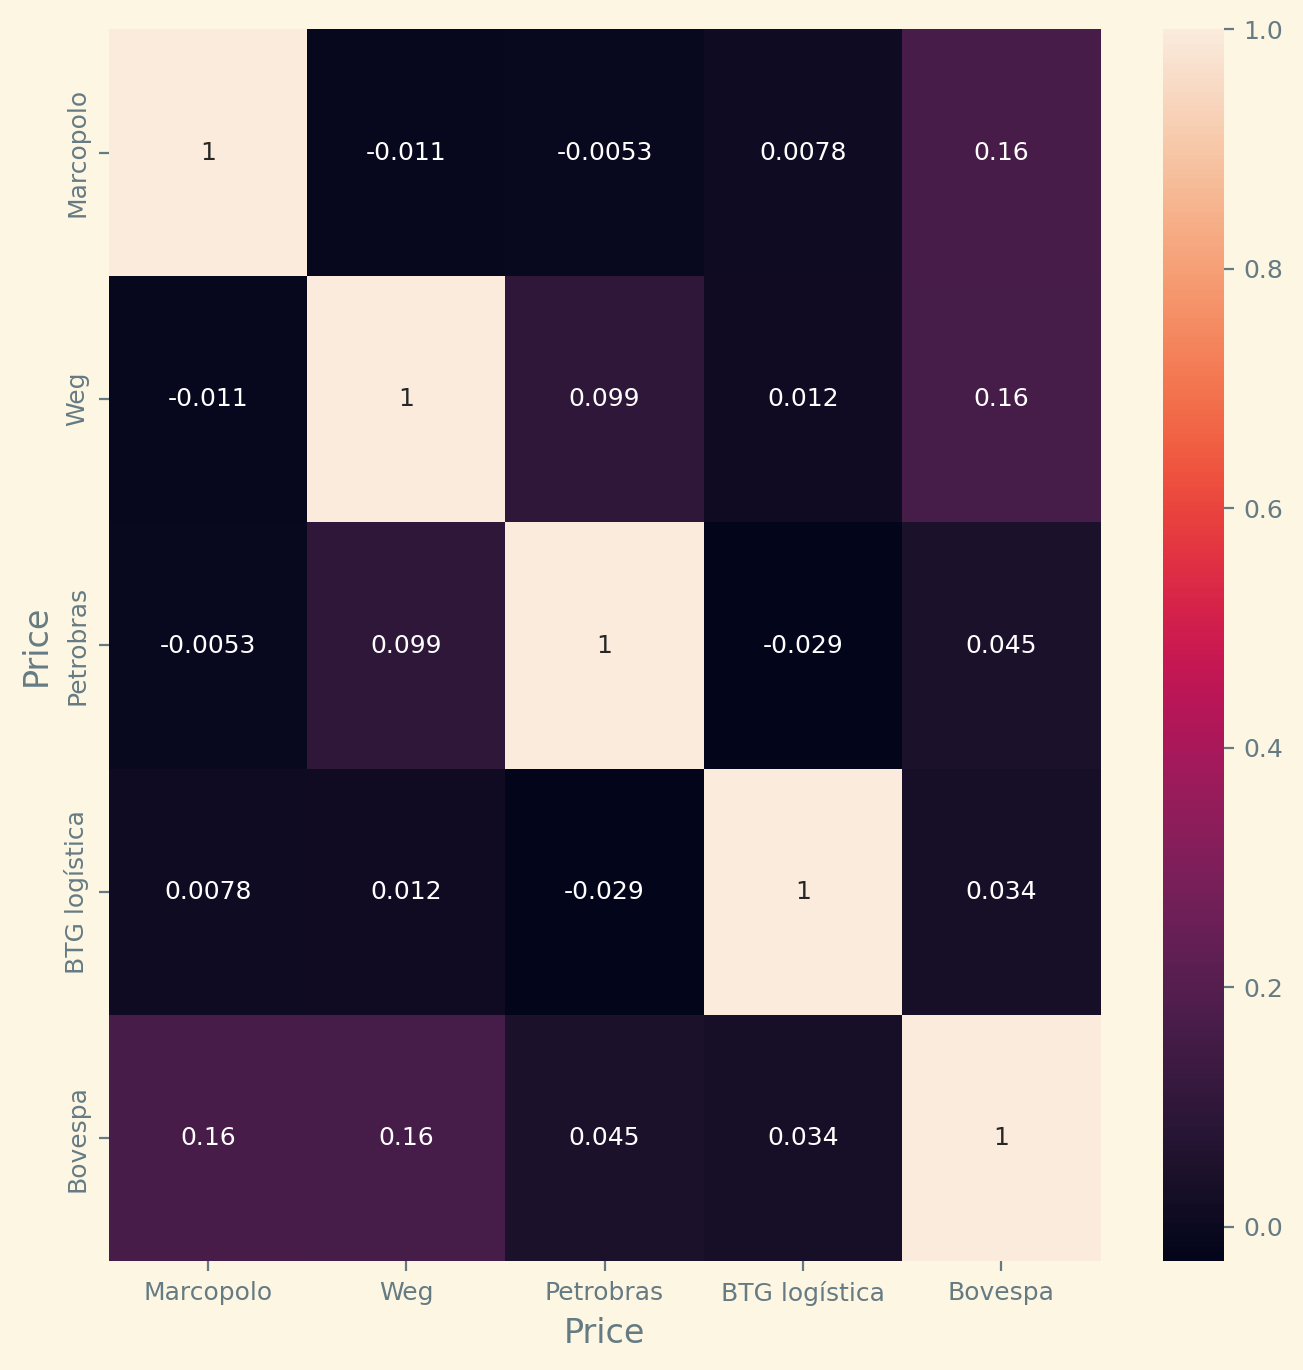

In [21]:
plt.figure(figsize=(8,8))
sns.heatmap(df_cor, annot=True);

### Covariância

A covariância é uma medida estatística que indica a direção do relacionamento linear entre duas variáveis, como os retornos de duas ações. Embora relacionada à correlação, a covariância possui algumas características e utilidades próprias:

- Medida de Direção: A covariância indica se duas ações tendem a se mover na mesma direção ou em direções opostas. Uma covariância positiva sugere que, em média, quando uma ação sobe, a outra também sobe. Uma covariância negativa indica que, quando uma ação sobe, a outra tende a descer.

- Construção de Portfólios: A covariância é fundamental na construção de portfólios, pois ajuda a calcular a variância de um portfólio. A variância do portfólio considera não apenas a variância individual de cada ativo, mas também a covariância entre todos os pares de ativos no portfólio. Isso é crucial para avaliar o risco total do portfólio.

- Análise de Risco: Ao analisar a covariância entre ativos, os investidores podem entender melhor como o risco é distribuído em um portfólio. Ativos com alta covariância podem aumentar o risco total do portfólio, enquanto ativos com baixa ou negativa covariância podem ajudar a reduzir o risco.

- Alocação de Ativos: A covariância ajuda na alocação de ativos, permitindo aos investidores escolher combinações de ativos que minimizam o risco para um dado nível de retorno esperado. Isso é parte do que é conhecido como a fronteira eficiente na teoria moderna de portfólios.

- Estratégias de Hedging: Investidores podem usar a covariância para identificar pares de ativos que podem ser usados em estratégias de hedging. Se dois ativos têm alta covariância, um investidor pode decidir usar um deles para proteger contra movimentos adversos no outro.

- Identificação de Relações de Mercado: A covariância pode ajudar a identificar como diferentes ativos ou setores se relacionam entre si, fornecendo insights sobre a dinâmica do mercado e possíveis oportunidades de investimento.

- Base para Correlação: Embora a covariância forneça informações sobre a direção do relacionamento entre duas variáveis, ela não é dimensionada, o que significa que não fornece a força do relacionamento de forma padronizada. Para isso, a correlação, que é a covariância normalizada, é usada, pois varia entre -1 e 1.

In [ ]:
# Taxa de covariância anual
def df_adj_close_cov():
    # Create a new DataFrame, excluding 'Date' and 'Carteira', without modifying df_adj_close
    df = df_adj_close.drop(labels=['Date', 'Carteira'], axis=1, inplace=False)
    df = df.pct_change()
    # Calculate the correlation matrix of df
    cov_matrix = df.cov()
    
    # Return the cov matrix
    return round(cov_matrix,5)

# Call the function to get and display the correlation matrix
df_cov = df_adj_close_cov()*len(df_adj_close)
df_cov 

Price,Marcopolo,Weg,Petrobras,BTG logística,Bovespa
Price,,,,,
Marcopolo,0.16128,-0.00000,-0.00000,0.00000,0.01764
Weg,-0.00000,0.06048,0.00504,0.00000,0.01008
Petrobras,-0.00000,0.00504,0.06300,-0.00000,0.00252
BTG logística,0.00000,0.00000,-0.00000,0.01008,0.00000
Bovespa,0.01764,0.01008,0.00252,0.00000,0.07560


In [ ]:
# composição da carteira para otimizar o retorno ajustado ao risco.
pesos = np.repeat(1/len(df_cov), len(df_cov))
np.dot(df_cov, pesos)

array([0.035784, 0.01512 , 0.014112, 0.002016, 0.021168])

In [ ]:
# Variância
variancia_portfolio = np.dot(pesos, np.dot(df_cov, pesos))
round(variancia_portfolio,5)

0.01764

In [ ]:
# SD - Votalidade
round(variancia_portfolio**0.5,5)*100

13.282

## Risco não sistemático

O risco não sistemático, também conhecido como risco específico ou idiossincrático, refere-se ao risco associado a um ativo ou grupo de ativos específicos, que não afeta o mercado como um todo. Esse tipo de risco é intrínseco a uma empresa ou setor e pode ser mitigado ou eliminado através da diversificação do portfólio. 

In [103]:
def calculate_risk_components(df_adj_close):
    # Drop 'Date' and 'Carteira' columns to focus on asset prices
    df = df_adj_close.drop(labels=['Date', 'Carteira'], axis=1, inplace=False)
    
    # Calculate percentage change to get returns
    df = df.pct_change().dropna()
    
    # Calculate covariance matrix of returns
    cov_matrix = df.cov() * len(df)
    
    # Define portfolio weights
    peso1 = np.array([0.25, 0.25, 0.25, 0.25, 0])
    peso2 = np.array([0, 0, 0, 0, 1])
    
    # Calculate portfolio variance using the covariance matrix
    port_variance1 = np.dot(peso1.T, np.dot(cov_matrix, peso1))
    port_variance2 = np.dot(peso2.T, np.dot(cov_matrix, peso2))
    
    # Calculate weighted variances for each portfolio
    var1 = np.dot(df.var() * len(df), peso1)
    var2 = np.dot(df.var() * len(df), peso2)
    
    # Calculate non-systematic risk components
    r_ns_1 = round(port_variance1 - var1, 4)
    r_ns_2 = round(port_variance2 - var2, 4)
    
    return r_ns_1, r_ns_2

calculate_risk_components(df_adj_close)


(-0.0544, 0.0)

# Forecasting Tradicional

In [14]:
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df_adj_close['Petrobras'])

(0.06281326919032364, True)

In [15]:
data = df_adj_close['Petrobras']
test_size = int(0.2 * len(data))
Y_train, y_test = data[:-test_size], data[-test_size:]
X_train, x_test = np.arange(Y_train.shape[0]), np.arange(Y_train.shape[0], data.shape[0])
X_train.shape, Y_train.shape, y_test.shape, x_test.shape

((202,), (202,), (50,), (50,))

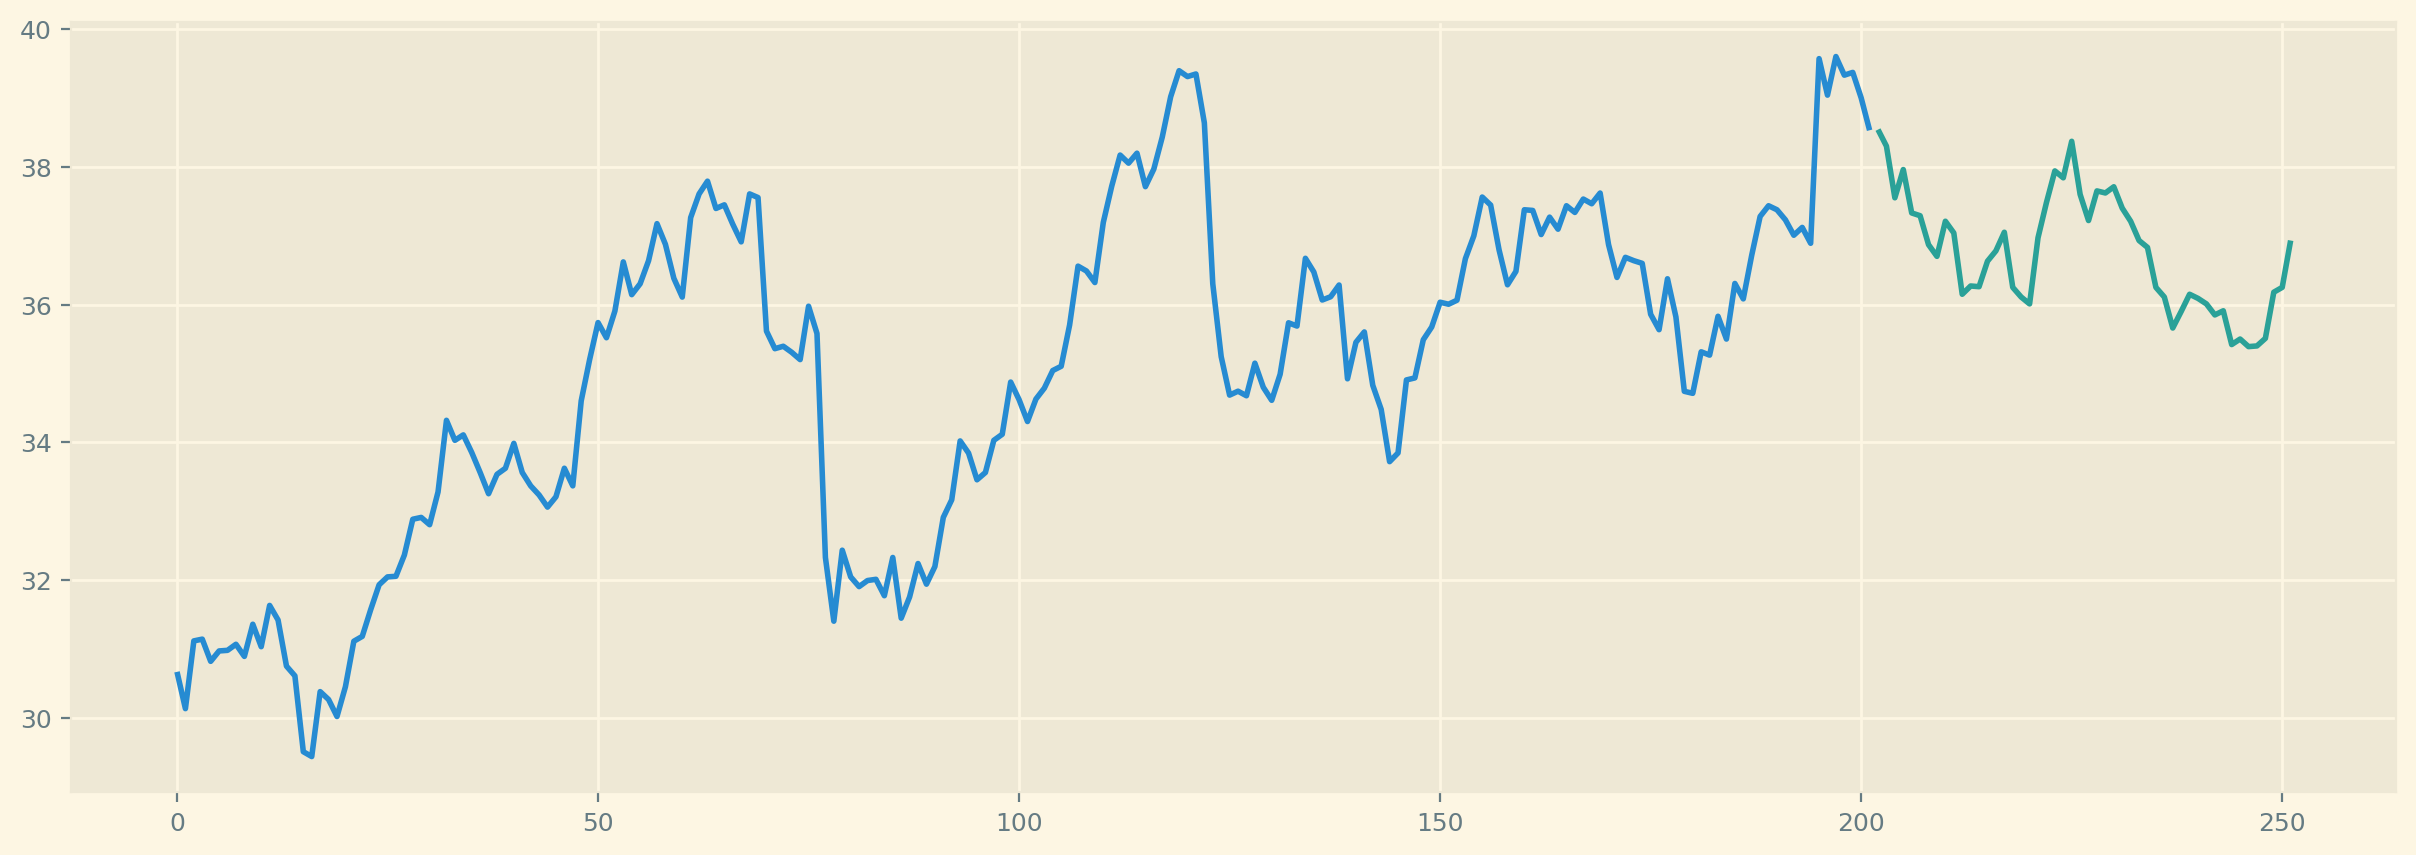

In [16]:
def plot_ts2():
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    ax.plot(X_train, Y_train)
    ax.plot(x_test, y_test)

plot_ts2()

In [ ]:
model_auto = auto_arima(Y_train, start_p=1, start_q=1,
                    #   exogenous=df[['seasonal_index']],
                      test='adf',
                      max_p=7, max_q=7,
                      m=7,             
                      d=1,          
                      seasonal=True,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
model_auto.summary()


In [18]:
n_periods = 20
forecast, conf_int = model_auto.predict(n_periods=n_periods, return_conf_int=True)

forecast_index = pd.date_range(df_adj_close.index[-1] + pd.Timedelta(days=1), periods=n_periods, freq='D')
forecast_df = pd.DataFrame({'Forecast': forecast, 'Lower CI': conf_int[:, 0], 'Upper CI': conf_int[:, 1]}, index=forecast_index)

TypeError: unsupported operand type(s) for +: 'int' and 'Timedelta'

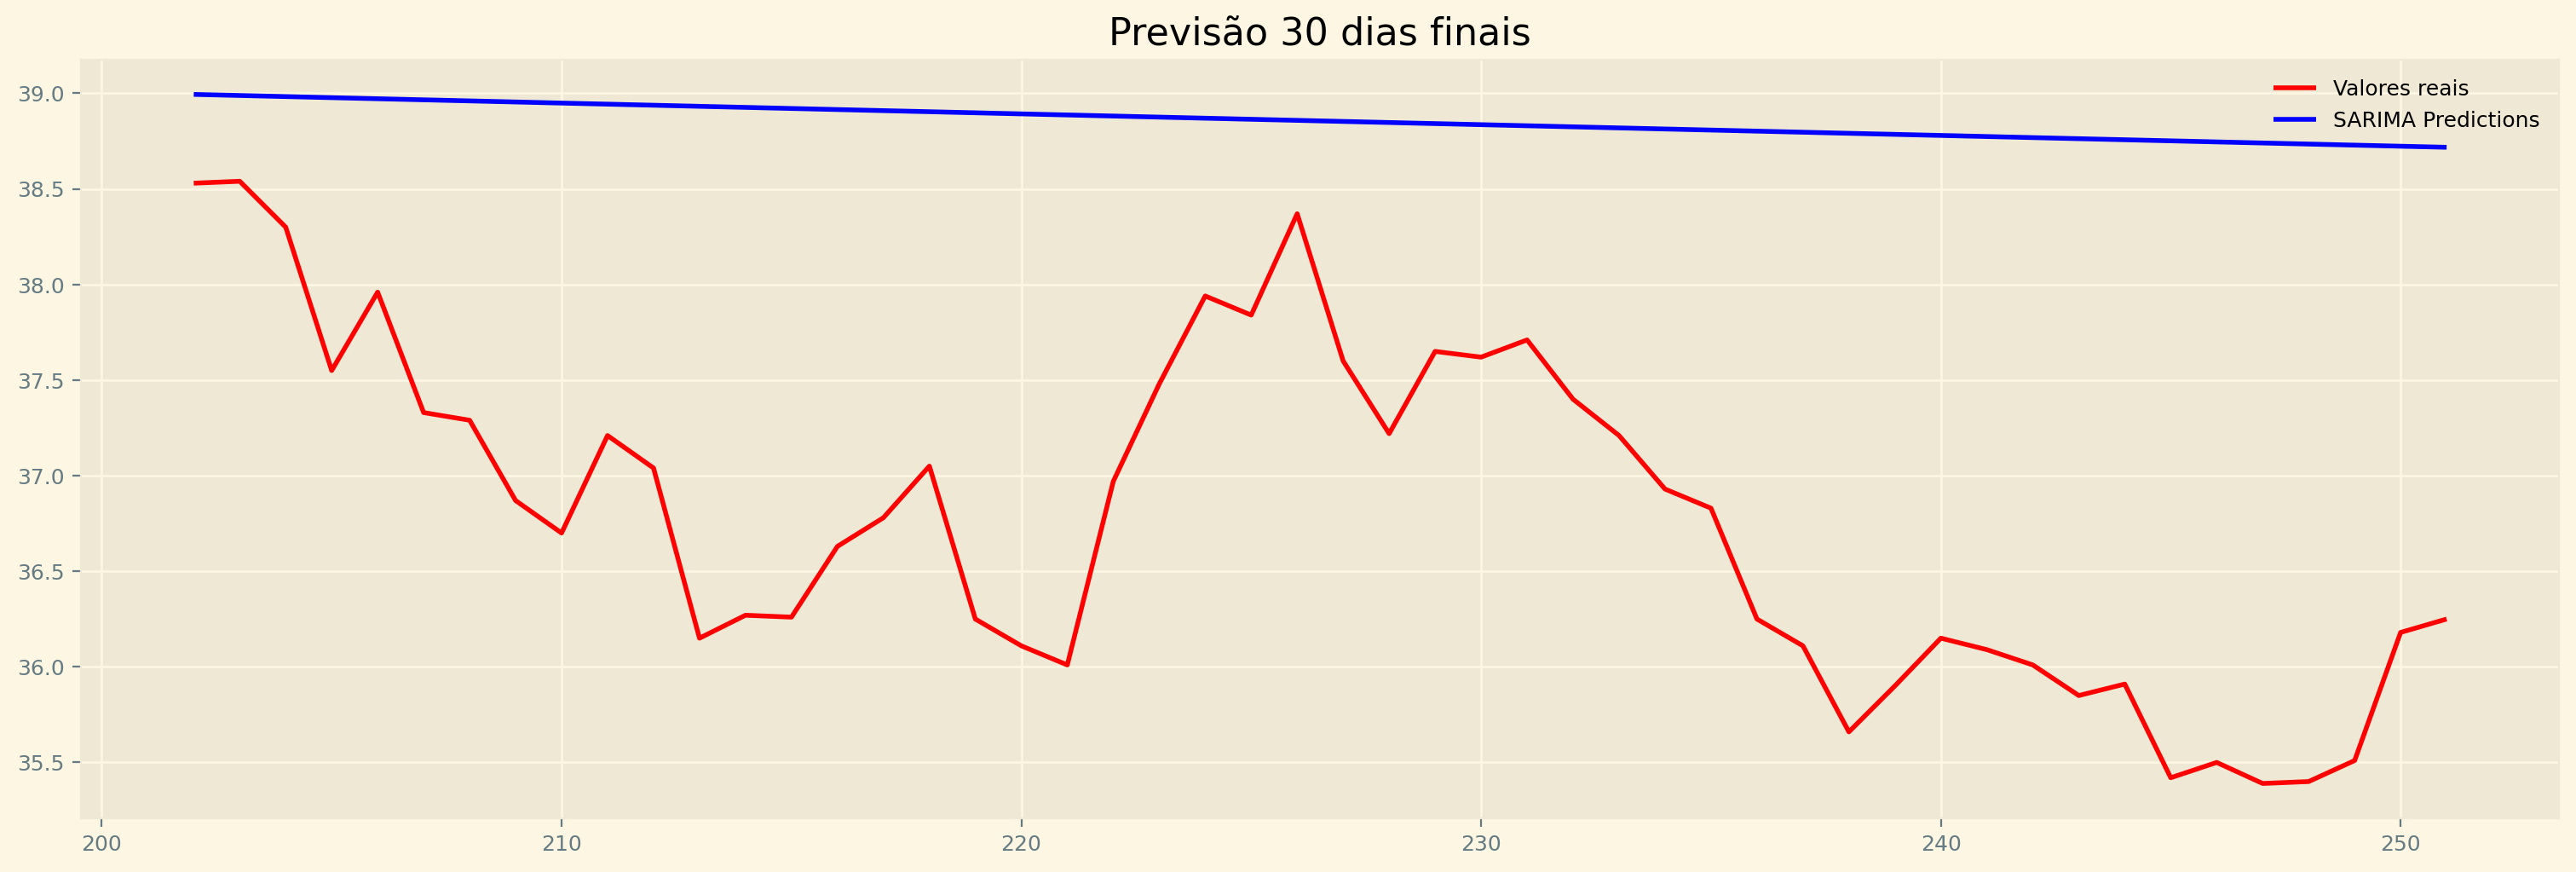

TypeError: got an unexpected keyword argument 'squared'

In [99]:
model_sarima = SARIMAX(Y_train, model =  model_auto.order)
model_sarima = model_sarima.fit()

def pred_sarima():
    y_pred = model_sarima.get_forecast(len(y_test.index))
    y_pred_df = y_pred.conf_int(alpha = 0.05)
    y_pred_df['Predictions'] = model_sarima.predict(start = y_pred_df.index[0], 
                                                    end = y_pred_df.index[-1])
    y_pred_df.index = y_test.index
    y_pred_out = y_pred_df["Predictions"] 
    fig, ax = plt.subplots(constrained_layout=True)
    fig.set_size_inches(15, 5)
    plt.plot(y_test, color = "red", label = 'Valores reais')
    plt.plot(y_pred_out, color='Blue', label = 'SARIMA Predictions')
    plt.legend(loc='upper right', frameon=False)
    plt.title('Previsão 30 dias finais')
    plt.show()
    testScore1 = root_mean_squared_error(y_test, y_pred_out, squared = False)
    print('RMSE: %.2f' % (testScore1))

pred_sarima()


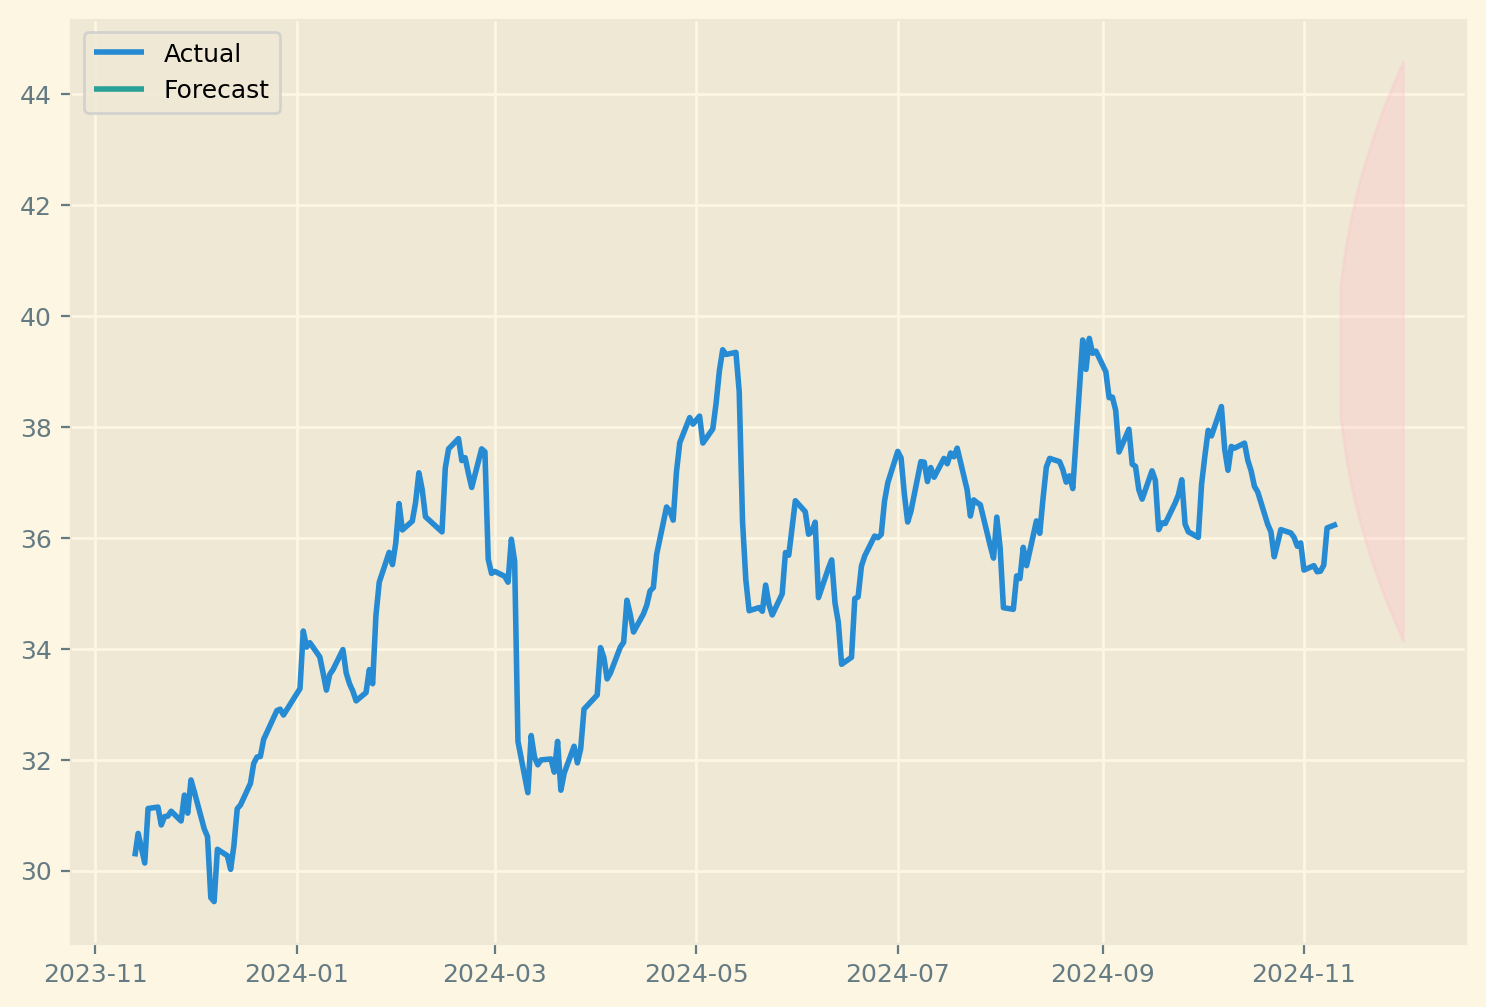

In [37]:
# Plotting
plt.figure(figsize=(9, 6))
plt.plot(df_adj_close['Petrobras'], label='Actual')
plt.plot(forecast_df['Forecast'], label='Forecast')
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], color='pink', alpha=0.3)
plt.legend()
plt.show()

In [38]:
scaler = MinMaxScaler(feature_range=(-1,1))
data_scaled = scaler.fit_transform(df_adj_close['Petrobras'].values.reshape(-1,1))

def create_seq(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return torch.FloatTensor(sequences), torch.FloatTensor(labels)

seq_length = 10
X, y = create_seq(data_scaled, seq_length)

X_train, x_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

class LSTM(nn.Module):
    def __init__(self,input_size = 1, hidden_layer_size = 50, output_size = 1):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1, self.hidden_layer_size),
                            torch.zeros(1,1, self.hidden_layer_size))

    def forward(self, input_seq):
        # Initialize hidden state and cell state at the start of each forward pass
        batch_size = input_seq.shape[1] if len(input_seq.shape) > 1 else 1  # Handle single or batch input
        self.hidden_cell = (
            torch.zeros(1, batch_size, self.hidden_layer_size).to(input_seq.device),
            torch.zeros(1, batch_size, self.hidden_layer_size).to(input_seq.device)
        )

        # Reshape input to LSTM's expected input format: [seq_len, batch_size, input_size]
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), batch_size, -1), self.hidden_cell)

        # Pass the last output of the LSTM through the linear layer
        predictions = self.linear(lstm_out.view(len(input_seq), batch_size, -1)[-1])  # Get last time step's output
        
        return predictions

# Forescating - LSTM

In [39]:
model = LSTM() 
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

epochs = 100
for epoch in range(epochs):
    for seq, label in zip(X_train, y_train):
        optimizer.zero_grad()  # Reset gradients
        model.hidden_cell = (
            torch.zeros(1, 1, model.hidden_layer_size),
            torch.zeros(1, 1, model.hidden_layer_size)
        ) 

        y_pred = model(seq)
        single_loss = loss_function(y_pred, label)
        single_loss.backward()  # Perform backpropagation
        optimizer.step()  

    if epoch % 10 == 0:
        print(f'Epoch {epoch} Loss: {single_loss.item()}')

print(f'Final Loss: {single_loss.item()}')

Epoch 0 Loss: 0.06444478034973145
Epoch 10 Loss: 0.0035694418475031853
Epoch 20 Loss: 0.0008210266241803765
Epoch 30 Loss: 0.0007104455144144595
Epoch 40 Loss: 0.0006246591219678521
Epoch 50 Loss: 0.0004755510890390724
Epoch 60 Loss: 6.10700881225057e-05
Epoch 70 Loss: 0.00010406176443211734
Epoch 80 Loss: 2.4792893782432657e-06
Epoch 90 Loss: 0.0005329749546945095
Final Loss: 0.0033902067225426435


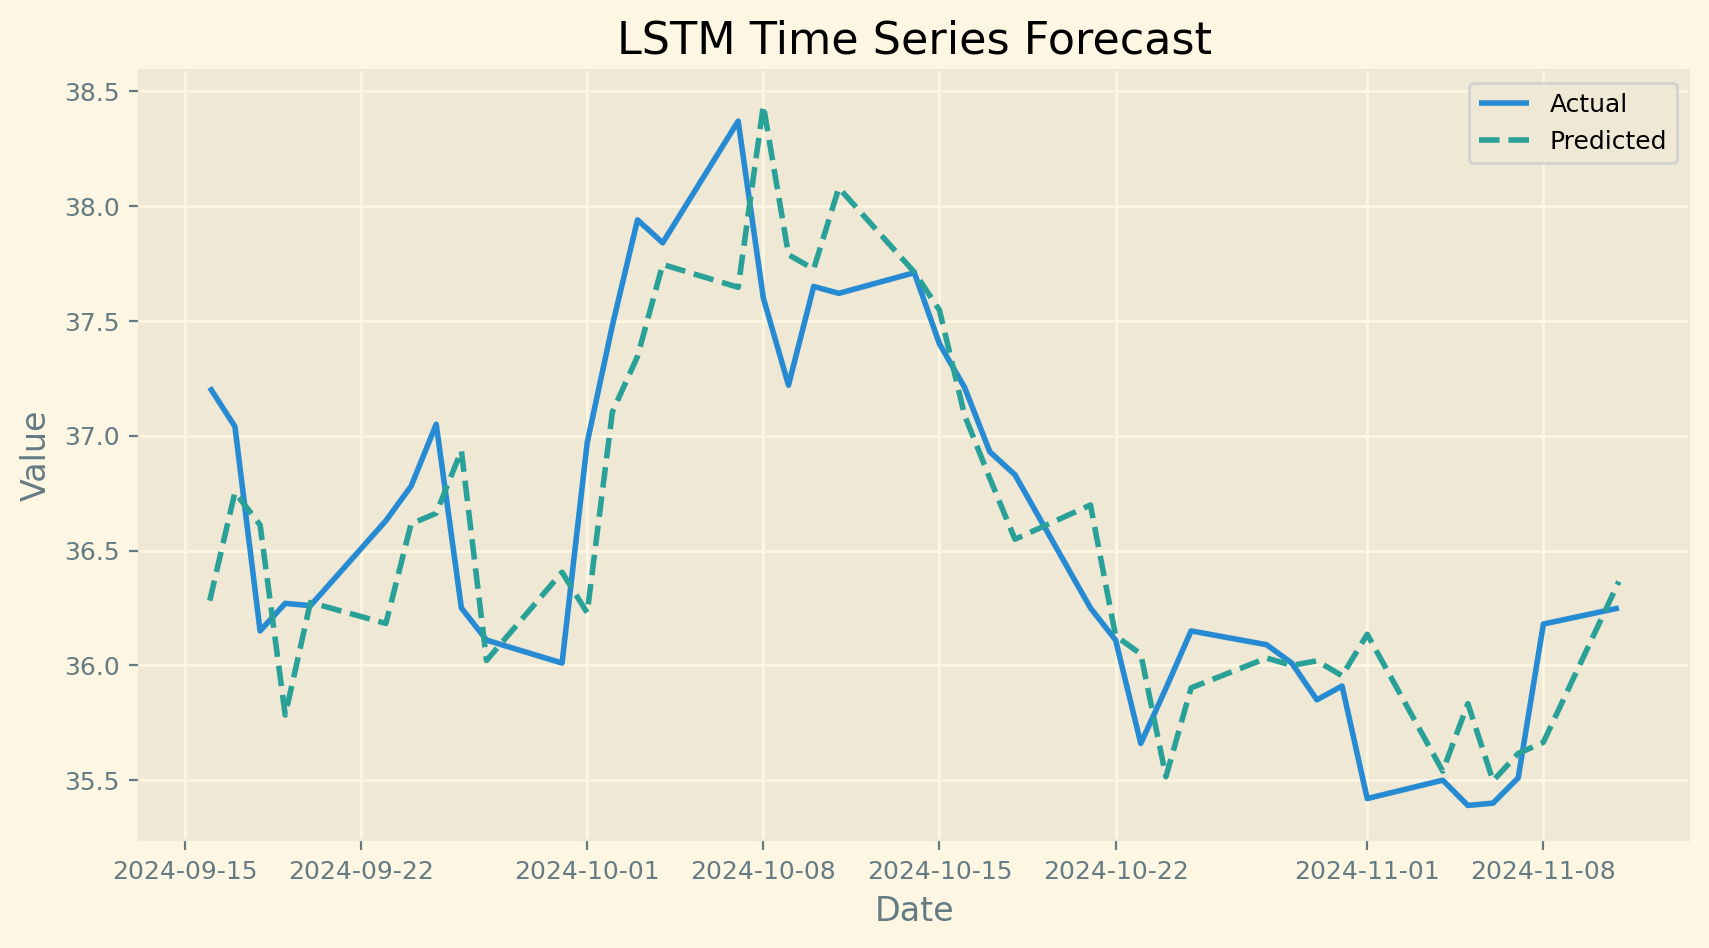

In [40]:
# Initialize an empty list to store predictions
predictions = []

# Set model to evaluation mode
model.eval()
with torch.no_grad():  # Disable gradient calculation for inference
    for seq in x_test:
        model.hidden_cell = (
            torch.zeros(1, 1, model.hidden_layer_size),
            torch.zeros(1, 1, model.hidden_layer_size)
        )
        predictions.append(model(seq).item())  # Get the scalar prediction and append to list

# Convert predictions and test labels back to the original scale
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(10,5))
plt.plot(df_adj_close.index[-len(y_test):], y_test, label='Actual')
plt.plot(df_adj_close.index[-len(predictions):], predictions, label='Predicted', linestyle='--')
plt.title('LSTM Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()